In [20]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import seaborn as sns
sns.set_style('ticks')
sns.set_context('paper')
from RiboGraphViz import RGV
from RiboGraphViz import LoopExtruder, StackExtruder
from ipynb.draw import draw_struct

from nnn import util, fileio, processing, plotting, motif_fit

import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from scipy import stats
from sklearn.metrics import r2_score

In [30]:
annotation = pd.read_csv('./data/annotation/NNNlib2b_annotation_struct.tsv', sep='\t').set_index('SEQID')
r1 = fileio.read_fitted_variant('./data/fitted_variant/NNNlib2b_DNA_20211022_v6.CPvariant.gz')
r2 = fileio.read_fitted_variant('./data/fitted_variant/NNNlib2b_DNA_20211216.CPvariant.gz')
r3 = fileio.read_fitted_variant('./data/fitted_variant/NNNlib2b_DNA_20211221_v8.CPvariant.gz')
r4 = fileio.read_fitted_variant('./data/fitted_variant/NNNlib2b_DNA_20211223_v6.CPvariant.gz')

30987 / 32379, 95.70% varaints passed the chi2 test
86.43% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
28424 / 28756, 98.85% varaints passed the chi2 test
86.41% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
28539 / 28756, 99.25% varaints passed the chi2 test
86.08% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
28014 / 28755, 97.42% varaints passed the chi2 test
81.31% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5


## Forward-reverse vs forward replicates

In [15]:
df = r3[['dG_37']].join( r4[['dG_37']], lsuffix='_melt', rsuffix='_anneal' , how='inner')
r2_score(df.dG_37_melt, df.dG_37_anneal)

0.8579214986973616

In [17]:
df = r2[['dG_37']].join( r3[['dG_37']], lsuffix='_melt_r1', rsuffix='_melt_r2' , how='inner')
r2_score(df.dG_37_melt_r1, df.dG_37_melt_r2)

0.9832156548212994

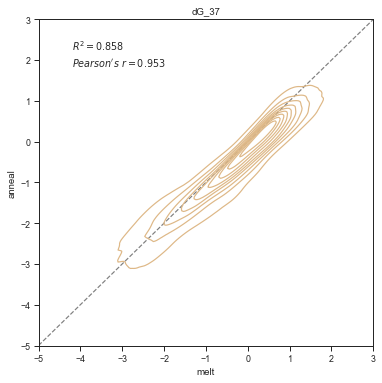

In [24]:
plotting.plot_rep_comparison(r3, r4, param='dG_37', lim=[-5,3], kind='kde')
plt.xlabel('melt')
plt.ylabel('anneal')
util.save_fig('./fig/melt_anneal/compare_all_melt-anneal.pdf')

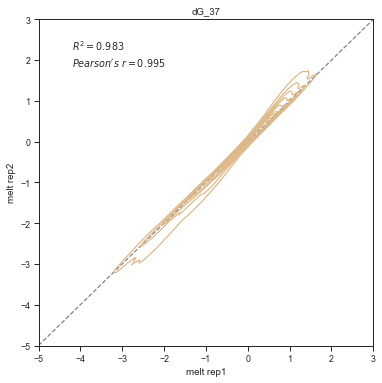

In [25]:
plotting.plot_rep_comparison(r2, r3, param='dG_37', lim=[-5,3], kind='kde')
plt.xlabel('melt rep1')
plt.ylabel('melt rep2')
util.save_fig('./fig/melt_anneal/compare_all_melt-reps.pdf')

Series Bulges,  8432 variants
Series TETRAloop,  3768 variants
Series MisMatchesGTanyPos,  3367 variants
Series MisMatchesACanyPos,  2719 variants
Series MisMatchesCentered,  2449 variants
Series WatsonCrick,  2275 variants
Series TRIloop,  954 variants
Series PUMcontrols,  30 variants
Series REPeatControls,  28 variants
Series BaeControls,  6 variants
Series PolyNTControls,  6 variants
Series VariableLoops,  6 variants


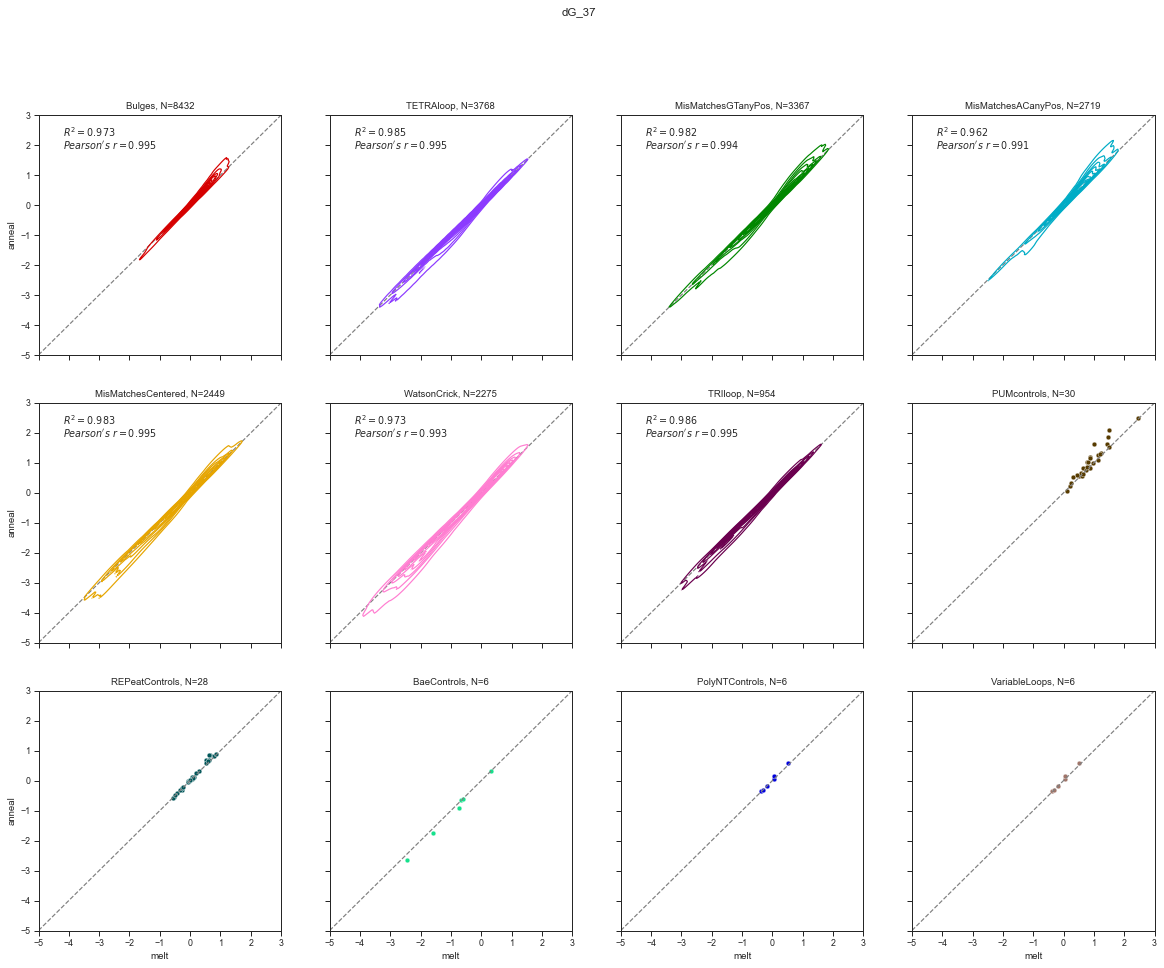

In [34]:
plotting.plot_rep_comparison_by_series(r2, r3, annotation, param='dG_37', lim=[-5,3],
        suffixes=('_x', '_y'), xlabel='melt', ylabel='anneal')
util.save_fig('./fig/melt_anneal/dG_37_by_series_rep.pdf')

## Does NUPACK predict non-two-state behavior?

In [36]:
annotation['fold_agree'] = annotation.TargetStruct == annotation.mfe_struct_Na_1M_0C

In [50]:
class_agree = annotation.groupby('ConstructClass').sum()[['fold_agree']].join(pd.DataFrame(annotation.groupby('ConstructClass').apply(len), columns=['num']))
class_agree = class_agree.drop('Pseudo knots')

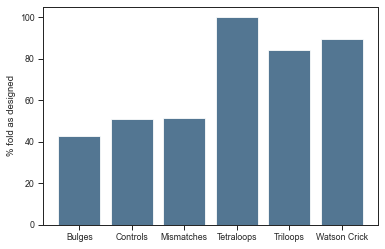

In [61]:
plt.bar(class_agree.index, 100 * class_agree.fold_agree / class_agree.num, color='#537692')
plt.ylabel('% fold as designed')
util.save_fig('./fig/folding/percent_fold_as_designed.pdf')

In [131]:
r3.columns

Index(['Green12_20.0_norm', 'Green12_20.0_norm_std', 'Green13_22.5_norm',
       'Green13_22.5_norm_std', 'Green14_25.0_norm', 'Green14_25.0_norm_std',
       'Green15_27.5_norm', 'Green15_27.5_norm_std', 'Green16_30.0_norm',
       'Green16_30.0_norm_std', 'Green17_32.5_norm', 'Green17_32.5_norm_std',
       'Green18_35.0_norm', 'Green18_35.0_norm_std', 'Green19_37.5_norm',
       'Green19_37.5_norm_std', 'Green20_40.0_norm', 'Green20_40.0_norm_std',
       'Green21_42.5_norm', 'Green21_42.5_norm_std', 'Green22_45.0_norm',
       'Green22_45.0_norm_std', 'Green23_47.5_norm', 'Green23_47.5_norm_std',
       'Green24_50.0_norm', 'Green24_50.0_norm_std', 'Green25_52.5_norm',
       'Green25_52.5_norm_std', 'Green26_55.0_norm', 'Green26_55.0_norm_std',
       'Green27_57.5_norm', 'Green27_57.5_norm_std', 'Green28_60.0_norm',
       'Green28_60.0_norm_std', 'RMSE', 'Tm', 'Tm_lb', 'Tm_se', 'Tm_ub',
       'chisq', 'dG_37', 'dG_37_lb', 'dG_37_se', 'dG_37_ub', 'dH', 'dH_lb',
       'dH_se', '

In [132]:
r1_anno = r3.join(annotation)

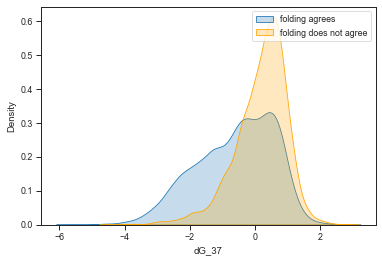

In [147]:
metric = 'dG_37'
fold_agree_red_chisq = r1_anno[r1_anno.fold_agree][metric]
fold_not_agree_red_chisq = r1_anno[np.logical_not(r1_anno.fold_agree)][metric]

sns.kdeplot(fold_agree_red_chisq.values, fill=True)
sns.kdeplot(fold_not_agree_red_chisq, color='orange', fill=True)
# plt.xlim([0,2])
plt.legend(['folding agrees', 'folding does not agree'])
util.save_fig(f'./fig/folding/fold_agree_{metric}.pdf')

In [89]:
fold_agree_red_chisq.sum() / len(fold_agree_red_chisq)

0.9898371762648891

In [90]:
fold_not_agree_red_chisq.sum() / len(fold_not_agree_red_chisq)

0.9863931553448099

<AxesSubplot:xlabel='chisq'>

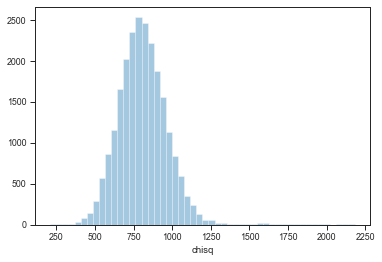

In [100]:
sns.distplot(r4.chisq, kde=False)